# Import libraries

In [1]:
import datetime
import gpm
from gpm.utils.geospatial import get_country_extent
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from pyresample import geometry, kd_tree
import pandas as pd
import h5py
import os

# Output directory

In [2]:
# Output dir of the resampled files 
output_dir = r'D:\Ghana\IMERG_data\Resampled_nat\Native\testje'

# Looding the data from gpm library

In [3]:
# Specify the time period you are interested in
start_time = datetime.datetime.strptime("2022-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2022-01-01 01:00:00", "%Y-%m-%d %H:%M:%S")

# Specify the product and product type
product = "IMERG-FR"  # 'IMERG-ER' 'IMERG-LR'
product_type = "RS"  # "NRT"

# Specify the version
version = 7

# - If chunks is not None, it does not load the data in RAM memory !
ds = gpm.open_dataset(
    product=product,
    product_type=product_type,
    version=version,
    start_time=start_time,
    end_time=end_time,
    #variables=["precipitation", "probabilityLiquidPrecipitation"],
)
ds

C:\Users\c.kwa\AppData\Local\miniforge3\envs\gpm-api-py311\Lib\site-packages\gpm\dataset\dataset.py:345: GPM_Warning: 'Missing timesteps across the dataset !'
  ds = finalize_dataset(
C:\Users\c.kwa\AppData\Local\miniforge3\envs\gpm-api-py311\Lib\site-packages\gpm\dataset\dataset.py:358: GPM_Warning: 'The GPM Dataset has missing granules !'
  warnings.warn(msg, GPM_Warning, stacklevel=1)


<xarray.Dataset> Size: 1GB
Dimensions:                         (time: 4, lat: 1800, lon: 3600, lonv: 2,
                                     latv: 2, nv: 2)
Coordinates:
    lon_bnds                        (lonv, lon) float32 29kB dask.array<chunksize=(2, 3600), meta=np.ndarray>
    lat_bnds                        (latv, lat) float32 14kB dask.array<chunksize=(2, 1800), meta=np.ndarray>
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
    time_bnds                       (time, nv) datetime64[ns] 64B 2022-01-01 ...
  * time                            (time) datetime64[ns] 32B 2022-01-01T00:3...
    crsWGS84                        int64 8B 0
Dimensions without coordinates: lonv, latv, nv
Data variables:
    precipitation                   (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    precipitationQualityIndex       (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    MWprecipitation                 (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    MWprecipSource                  (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    MWobservationTime               (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    IRprecipitation                 (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    IRinfluence                     (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    precipitationUncal              (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/15)
    FileName:           3B-HHR.MS.MRG.3IMERG.20220101-S000000-E002959.0000.V0...
    MissingData:        
    DOI:                10.5067/GPM/IMERG/3B-HH/07
    DOIauthority:       http://dx.doi.org/
    AlgorithmID:        3IMERGHH
    AlgorithmVersion:   3IMERGH_7.0
    ...                 ...
    ProcessingSystem:   PPS
    DataFormatVersion:  7e
    MetadataVersion:    7e
    ScanMode:           Grid
    history:            Created by ghiggi/gpm_api software on 2025-03-05 09:5...
    gpm_api_product:    IMERG-FR

# Check available variables

In [4]:
# Available variables
variables = list(ds.data_vars)
print("Available variables: ", variables)
# Available coordinates
coords = list(ds.coords)
print("Available coordinates: ", coords)
# Available dimensions
dims = list(ds.dims)
print("Available dimensions: ", dims)

Available variables:  ['precipitation', 'randomError', 'probabilityLiquidPrecipitation', 'precipitationQualityIndex', 'MWprecipitation', 'MWprecipSource', 'MWobservationTime', 'IRprecipitation', 'IRinfluence', 'precipitationUncal']
Available coordinates:  ['lon_bnds', 'lat_bnds', 'lon', 'lat', 'time_bnds', 'time', 'crsWGS84']
Available dimensions:  ['time', 'lat', 'lon', 'lonv', 'latv', 'nv']


# Resample to same resolution as SEVIRI data

First loading in the seviri file to get grid to resample to.

In [5]:
# Load the SEVIRI file
file_name = 'MSG4-SEVI-MSG15-0100-NA-20200501001242.772000000Z-NA.hdf5'
file_path = fr'C:\Users\c.kwa\Desktop\meteosat_retrieval\SEVIRI_retrieval\Test_batch\Native_to_h5\hdf5\2020\05\{file_name}'
seviri_ds = xr.open_dataset(file_path, engine = 'netcdf4')

# Print dataset information (variables and dimensions)
seviri_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 248, x: 184)
Coordinates:
  * y        (y) float64 2kB 11.29 11.26 11.23 11.2 ... 4.596 4.569 4.541 4.514
  * x        (x) float64 1kB -3.686 -3.659 -3.631 -3.604 ... 1.281 1.309 1.336
Data variables:
    my_area  int64 8B ...
    IR_016   (y, x) float32 183kB ...
    IR_039   (y, x) float32 183kB ...
    IR_087   (y, x) float32 183kB ...
    IR_097   (y, x) float32 183kB ...
    IR_108   (y, x) float32 183kB ...
    IR_120   (y, x) float32 183kB ...
    IR_134   (y, x) float32 183kB ...
    VIS006   (y, x) float32 183kB ...
    VIS008   (y, x) float32 183kB ...
    WV_062   (y, x) float32 183kB ...
    WV_073   (y, x) float32 183kB ...
Attributes:
    history:      Created by pytroll/satpy on 2024-10-29 20:30:28.976939
    Conventions:  CF-1.7

Cropping the files by the extend of the seviri file

In [6]:
# Bounding box (in degrees)
min_lon = seviri_ds['x'].min().item()
max_lon = seviri_ds['x'].max().item()
min_lat = seviri_ds['y'].min().item()
max_lat = seviri_ds['y'].max().item()
print(min_lon, max_lon, min_lat, max_lat)

-3.6862771739130435 1.336277173913044 4.513709677419355 11.286290322580646


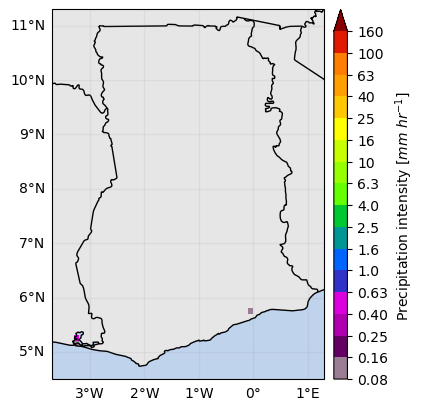

In [7]:
# Crop by extent
variable = 'precipitation'
extent = get_country_extent("Ghana")
ds_ghana = ds.gpm.crop(extent=[min_lon, max_lon, min_lat, max_lat])
ds_ghana[variable].isel(time=2).gpm.plot_map()

# Resample resolution
Resample the file to the same resolution, using nearest neigbour resampling

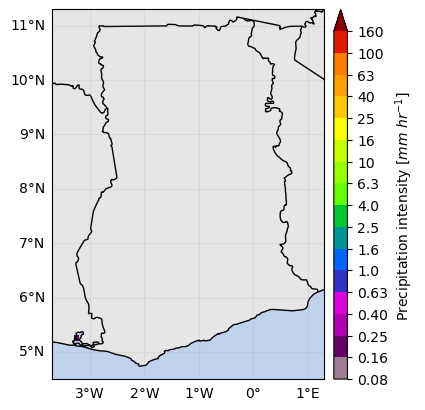

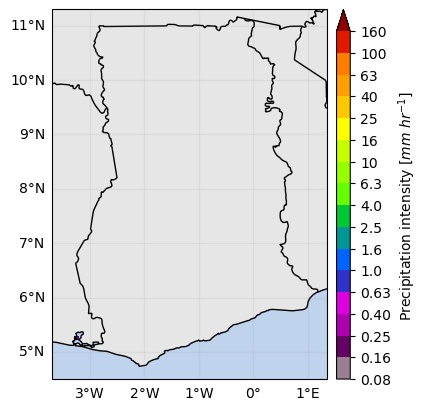

In [8]:
#  Create a new DataArray with the new lat/lon grid
ds_resampled = ds.interp(lon=seviri_ds.x, lat=seviri_ds.y[::-1], method="nearest")
ds_ghana[variable].isel(time=0).gpm.plot_map()
ds_resampled[variable].isel(time=0).gpm.plot_map()

In [9]:
ds_resampled

<xarray.Dataset> Size: 7MB
Dimensions:                         (time: 4, y: 248, x: 184, lonv: 2, latv: 2,
                                     nv: 2)
Coordinates:
    lon_bnds                        (lonv, x) float32 1kB dask.array<chunksize=(2, 184), meta=np.ndarray>
    lat_bnds                        (latv, y) float32 2kB dask.array<chunksize=(2, 248), meta=np.ndarray>
    time_bnds                       (time, nv) datetime64[ns] 64B 2022-01-01 ...
  * time                            (time) datetime64[ns] 32B 2022-01-01T00:3...
    crsWGS84                        int64 8B 0
    lon                             (x) float64 1kB -3.686 -3.659 ... 1.336
    lat                             (y) float64 2kB 4.514 4.541 ... 11.26 11.29
  * x                               (x) float64 1kB -3.686 -3.659 ... 1.336
  * y                               (y) float64 2kB 4.514 4.541 ... 11.26 11.29
Dimensions without coordinates: lonv, latv, nv
Data variables:
    precipitation                   (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    randomError                     (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    precipitationQualityIndex       (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    MWprecipitation                 (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    MWprecipSource                  (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    MWobservationTime               (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    IRprecipitation                 (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    IRinfluence                     (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
    precipitationUncal              (time, y, x) float32 730kB dask.array<chunksize=(1, 248, 184), meta=np.ndarray>
Attributes: (12/15)
    FileName:           3B-HHR.MS.MRG.3IMERG.20220101-S000000-E002959.0000.V0...
    MissingData:        
    DOI:                10.5067/GPM/IMERG/3B-HH/07
    DOIauthority:       http://dx.doi.org/
    AlgorithmID:        3IMERGHH
    AlgorithmVersion:   3IMERGH_7.0
    ...                 ...
    ProcessingSystem:   PPS
    DataFormatVersion:  7e
    MetadataVersion:    7e
    ScanMode:           Grid
    history:            Created by ghiggi/gpm_api software on 2025-03-05 09:5...
    gpm_api_product:    IMERG-FR

# Save files
Saving the resampled files seperately

In [10]:
# Extract the precipitation variable along with its dimensions (time, lat, lon)
rsmpl_precip_ghana = ds_resampled[['precipitation']]

# Loop over each time step and save each timestep as a separate file
for i in range(len(rsmpl_precip_ghana.time)):
    # Select the i-th timestep
    precip_at_time = rsmpl_precip_ghana.isel(time=i)['precipitation']  # Select 'precipitation' DataArray
    
    # Extract the time as a datetime object
    time_value = pd.to_datetime(precip_at_time.time.values)
    print(time_value)
    
    # Construct the filename based on the desired format
    
    end_time_str = (time_value  - pd.Timedelta(seconds = 1)).strftime("E%H%M%S")# Format: S-HHMMSS
    start_time_str = (time_value - pd.Timedelta(minutes=30)).strftime("S%H%M%S")  # Assuming 30 min intervals
    date_str = pd.to_datetime(time_value - pd.Timedelta(minutes=30)).strftime("%Y%m%d")  # Format: YYYYMMDD

    filename = f"3B-HHR.MS.MRG.3IMERG.{date_str}-{start_time_str}-{end_time_str}.0000.V07B.resampled.HDF5"
    print(filename)

    year = date_str[0:4]
    month = date_str[4:6]
    file_dir = os.path.join(output_dir, year, month)
    
    #if not os.path.exists(file_dir):
    os.makedirs(file_dir, exist_ok = True)
    
    filepath = fr'{file_dir}\\{filename}'

    # output_dirc = fr'{filepath}'
    # ds.to_netcdf(output_dirc)

    if not os.path.exists(filepath):
        # Save the data as an HDF5 file
        with h5py.File(filepath, 'w') as new_file:
            # Convert the DataArray to a NumPy array and save it
            new_file.create_dataset('IMERG_FR', data=precip_at_time.values)
            
            # Check if 'lon' and 'lat' grids exist in the data
            if 'lon' in precip_at_time.coords and 'lat' in precip_at_time.coords:
                # Extract and save longitude and latitude data
                lon_data = precip_at_time['lon'].values
                lat_data = precip_at_time['lat'].values
    
                new_file.create_dataset('lon', data=lon_data)
                new_file.create_dataset('lat', data=lat_data)

    # print(f"Saved file: {filename}")

print("All files saved successfully.")

2022-01-01 00:30:00
3B-HHR.MS.MRG.3IMERG.20220101-S000000-E002959.0000.V07B.resampled.HDF5
2022-01-01 00:30:00
3B-HHR.MS.MRG.3IMERG.20220101-S000000-E002959.0000.V07B.resampled.HDF5
2022-01-01 01:00:00
3B-HHR.MS.MRG.3IMERG.20220101-S003000-E005959.0000.V07B.resampled.HDF5
2022-01-01 01:00:00
3B-HHR.MS.MRG.3IMERG.20220101-S003000-E005959.0000.V07B.resampled.HDF5
All files saved successfully.
